# ThumbTack Analytics Challenge

Prompt: Thumbtack has decided to take a closer look at performance in two of its largest categories - House Cleaning and Local Moving.

Please summarize, based on your analysis of the provided data, what types of pros our customers are interested in (What metrics do you choose to quantify customers’ interest?).  

Justify your recommendations based on your analysis of the provided data.

### Step 1: Import python packages and datasets

In [59]:
# Data Imports
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# Plot imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# For evaluating our ML results
from sklearn import metrics

#Import datetime packages
from datetime import datetime
from datetime import timedelta

# Dataset Import
contacts_df = pd.read_csv('C:\\Users\\sidhp\\Desktop\\Summer 2020\\ISYE4803\\Final Project\\ThumbTack Analytics Challenge Data\\Contacts.csv')
visitors_df = pd.read_csv('C:\\Users\\sidhp\\Desktop\\Summer 2020\\ISYE4803\\Final Project\\ThumbTack Analytics Challenge Data\\Visitors.csv')

import warnings
warnings.filterwarnings("ignore")

### Step 2: Generate descriptive statistics using .head(), .describe(), and .info()

In [60]:
contacts_df.head(3)

,visitor_id,pro_user_id,contact_id,hired
0,339909111505494000,269676229116822000,339909524915273000,False
1,344128984608088000,343705945283207000,344129090535645000,False
2,344283283738624000,198869800397579000,344283629941841000,False


In [61]:
visitors_df.head(3)

,row_number,visitor_id,search_timestamp,category,pro_user_id,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed
0,15173,344101422347558000,2018-11-26 15:43:43.365 UTC,Local Moving (under 50 miles),343959583718981000,0,NaN,NaN,NaN,6,False
1,8426,344461605879021000,2018-11-30 19:46:46.593 UTC,House Cleaning,344053677817806000,0,NaN,2018-11-29 00:32:46.809 UTC,8900.0,6,False
2,12809,344142189241475000,2018-11-27 03:03:09.969 UTC,House Cleaning,343931062348177000,0,NaN,NaN,10000.0,21,False


In [62]:
contacts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 4 columns):
visitor_id     1504 non-null int64
pro_user_id    1504 non-null int64
contact_id     1504 non-null int64
hired          1504 non-null bool
dtypes: bool(1), int64(3)
memory usage: 36.8 KB


As we can see, there are no missing data points in the contacts dataframe

In [63]:
visitors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26102 entries, 0 to 26101
Data columns (total 11 columns):
row_number                            26102 non-null int64
visitor_id                            26102 non-null int64
search_timestamp                      26102 non-null object
category                              26102 non-null object
pro_user_id                           26102 non-null int64
num_reviews                           26102 non-null int64
avg_rating                            24947 non-null float64
pro_last_active_time_before_search    25035 non-null object
cost_estimate_cents                   23944 non-null float64
result_position                       26102 non-null int64
service_page_viewed                   26102 non-null bool
dtypes: bool(1), float64(2), int64(5), object(3)
memory usage: 2.0+ MB


We seem to be missing values in a few columns in our visitors dataframe. Let's investigate further

### Step 3: Finding missing values

In [64]:
# check missing values in visitors data
visitors_df.isnull().sum()

row_number                               0
visitor_id                               0
search_timestamp                         0
category                                 0
pro_user_id                              0
num_reviews                              0
avg_rating                            1155
pro_last_active_time_before_search    1067
cost_estimate_cents                   2158
result_position                          0
service_page_viewed                      0
dtype: int64

In [65]:
print('Percent of missing "avg_rating" records is %.2f%%' %((visitors_df['avg_rating'].isnull().sum()/visitors_df.shape[0])*100))
print('Percent of missing "pro_last_active_time_before_search" records is %.2f%%' %((visitors_df['pro_last_active_time_before_search'].isnull().sum()/visitors_df.shape[0])*100))
print('Percent of missing "cost_estimate_cents" records is %.2f%%' %((visitors_df['cost_estimate_cents'].isnull().sum()/visitors_df.shape[0])*100))

Percent of missing "avg_rating" records is 4.42%
Percent of missing "pro_last_active_time_before_search" records is 4.09%
Percent of missing "cost_estimate_cents" records is 8.27%


Each column's missing data points can be filled with metrics found using the remaining data.

However, before we fill in missing values, we must join the visitors and contacts dataset on the unique pro and visitor ids.

Then seperate the combined data set into one containing Local Moving data and one containing House Cleaning data.

Once separated we can find appropriate metrics to fill our missing data.

This will make our analysis easier in the future.

In [66]:
# Left join datasets on both visitor_ids and pro_user_id
cv_df = pd.merge(visitors_df, contacts_df, on=['visitor_id', 'pro_user_id'], how= 'left')

In [67]:
# Create house cleaning dataset
hc_df = cv_df[cv_df['category']=='House Cleaning']

# Create local moving dataset
lm_df = cv_df[cv_df['category']=='Local Moving (under 50 miles)']

Now that we have seperated our dataset, we can find the missing values in each of these and find the appropriate values to fill them with.

In [68]:
# check missing values in house cleaning data
hc_df.isnull().sum()

row_number                                0
visitor_id                                0
search_timestamp                          0
category                                  0
pro_user_id                               0
num_reviews                               0
avg_rating                              889
pro_last_active_time_before_search      905
cost_estimate_cents                    1492
result_position                           0
service_page_viewed                       0
contact_id                            18245
hired                                 18245
dtype: int64

Because we joined the datasets, we know the NaN values arise from the observation not existing in the contacts dataframe.

We will replace NaN values for 'hired' with False.

Text(0.5, 0, 'avg_rating')

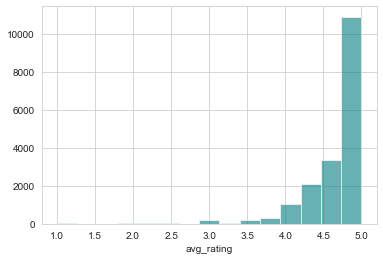

In [69]:
# Use a plot to understand the distribution of the avg_rating data in the House Cleaning dataset
hc_df["avg_rating"].hist(bins=15, stacked=True, color='teal', alpha=0.6)
plt.xlabel('avg_rating')

As we can see the large majority of pros have an extremely high rating. We will fill the missing avg_rating values with mean avg_rating

In [70]:
# mean avg_rating for House Cleaning
print('The mean of "avg_rating" is %.2f' %(hc_df["avg_rating"].mean(skipna=True)))

The mean of "avg_rating" is 4.68


In [71]:
# Let's investigate the pro_last_active_time_before_search timestamp values next
# We must first convert the str timestamp values into datetime objects to work with them
# We'll conver the data in the search_timestamp fisr
hc_df['search_timestamp'] = pd.to_datetime(hc_df['search_timestamp'])

# Let's do the same for the pro_last_active_time timestamp
hc_df['pro_last_active_time_before_search'] = pd.to_datetime(hc_df['pro_last_active_time_before_search'])

In [72]:
# Now lets make a column indicating how many days before the vistor's search the pro was last active
hc_df['days_since_pro_last_active'] = (hc_df['search_timestamp'] - hc_df['pro_last_active_time_before_search']).dt.days

In [73]:
hc_df.head()

,row_number,visitor_id,search_timestamp,category,pro_user_id,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed,contact_id,hired,days_since_pro_last_active
1,8426,344461605879021000,2018-11-30 19:46:46.593000+00:00,House Cleaning,344053677817806000,0,NaN,2018-11-29 00:32:46.809000+00:00,8900.0,6,False,NaN,NaN,1.0
2,12809,344142189241475000,2018-11-27 03:03:09.969000+00:00,House Cleaning,343931062348177000,0,NaN,NaT,10000.0,21,False,NaN,NaN,NaN
3,17310,344215295106097000,2018-11-27 23:21:35.890000+00:00,House Cleaning,343931062348177000,0,NaN,NaT,10000.0,22,False,NaN,NaN,NaN
4,10072,344364289304010000,2018-11-29 16:44:50.202000+00:00,House Cleaning,343934345272852000,0,NaN,NaT,9000.0,13,False,NaN,NaN,NaN
5,12571,344282205136609000,2018-11-28 17:56:45.914000+00:00,House Cleaning,343934345272852000,0,NaN,NaT,11000.0,25,False,NaN,NaN,NaN


Text(0.5, 0, 'days_since_pro_last_active')

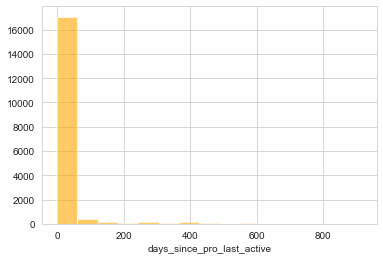

In [74]:
# Use a plot to understand the distribution of the days_since_last_active data in the House Cleaning dataset
hc_df["days_since_pro_last_active"].hist(bins=15, stacked=True, color='orange', alpha=0.6)
plt.xlabel('days_since_pro_last_active')

(0, 10)

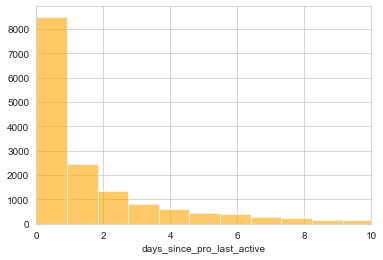

In [75]:
# Our distribution is slightly skewed to the right due to the large number of days since a minority of pros were last active
# Let's dive deeper
# Use a plot to understand the distribution of the days_since_last_active data in the House Cleaning dataset
hc_df["days_since_pro_last_active"].hist(bins=1000, stacked=True, color='orange', alpha=0.6)
plt.xlabel('days_since_pro_last_active')
plt.xlim(0,10)

The large majority of pros were active within a day of the search result. We will use this to fill the NaN values in our days_since_pro_last_active column. Furthermore, we can drop the 'search_timestamp' and column 'pro_last_active_time_before_search' from our dataset.

In [76]:
# mean days since last active
print('The mean of "days_since_pro_last_active" is %.2f' %(hc_df["days_since_pro_last_active"].mean(skipna=True)))
# median days since last active
print('The median of "days_since_pro_last_active" is %.2f' %(hc_df["days_since_pro_last_active"].median(skipna=True)))

The mean of "days_since_pro_last_active" is 18.16
The median of "days_since_pro_last_active" is 1.00


(0, 40000)

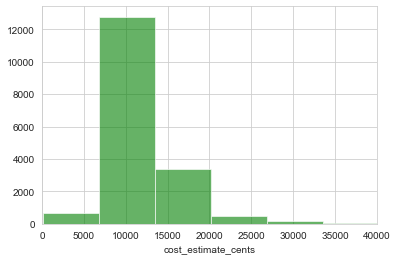

In [77]:
# Now let's look into the cost_estimate_cents data
# Use a plot to understand the distribution of the cost_estimate_cents data in the House Cleaning dataset
hc_df["cost_estimate_cents"].hist(bins=15, stacked=True, color='green', alpha=0.6)
plt.xlabel('cost_estimate_cents')
plt.xlim(0,40000)

In [78]:
# mean cost_estimate_cents
print('The mean of "cost_estimate_cents" is %.2f' %(hc_df["cost_estimate_cents"].mean(skipna=True)))
# median cost_estimate_cents
print('The median of "cost_estimate_cents" is %.2f' %(hc_df["cost_estimate_cents"].median(skipna=True)))

The mean of "cost_estimate_cents" is 11754.38
The median of "cost_estimate_cents" is 10800.00


As we can see here, the cost distribution is also slightly right skewed; therefore, we will use the median to fill our NaN values in the 'cost_estimate_cents' column.

### Now we are going to do the same investigation for the Local Moving dataset, before moving on to replacing the NaN data and performing explatory data analysis.

In [79]:
# check missing values in local moving data
lm_df.isnull().sum()

row_number                               0
visitor_id                               0
search_timestamp                         0
category                                 0
pro_user_id                              0
num_reviews                              0
avg_rating                             266
pro_last_active_time_before_search     162
cost_estimate_cents                    666
result_position                          0
service_page_viewed                      0
contact_id                            6353
hired                                 6353
dtype: int64

Text(0.5, 0, 'avg_rating')

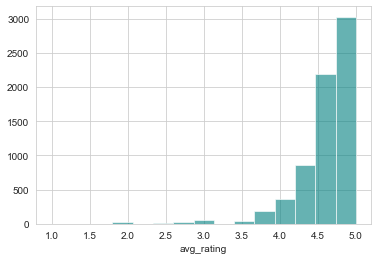

In [80]:
# Use a plot to understand the distribution of the avg_rating data in the Local Moving dataset
lm_df["avg_rating"].hist(bins=15, stacked=True, color='teal', alpha=0.6)
plt.xlabel('avg_rating')

In [81]:
# mean avg_rating for Local Moving
print('The mean of "avg_rating" is %.2f' %(lm_df["avg_rating"].mean(skipna=True)))

The mean of "avg_rating" is 4.63


We will use the mean avg_rating to replace the NaN values in our avg_rating columns

In [82]:
# Let's investigate the pro_last_active_time_before_search timestamp values next
# We must first convert the str timestamp values into datetime objects to work with them
# We'll conver the data in the search_timestamp fisr
lm_df['search_timestamp'] = pd.to_datetime(lm_df['search_timestamp'])

# Let's do the same for the pro_last_active_time timestamp
lm_df['pro_last_active_time_before_search'] = pd.to_datetime(lm_df['pro_last_active_time_before_search'])

In [83]:
# Now lets make a column indicating how many days before the vistor's search the pro was last active
lm_df['days_since_pro_last_active'] = (lm_df['search_timestamp'] - lm_df['pro_last_active_time_before_search']).dt.days

In [84]:
lm_df.head(2)

,row_number,visitor_id,search_timestamp,category,pro_user_id,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed,contact_id,hired,days_since_pro_last_active
0,15173,344101422347558000,2018-11-26 15:43:43.365000+00:00,Local Moving (under 50 miles),343959583718981000,0,NaN,NaT,NaN,6,False,NaN,NaN,NaN
10,17285,344105876235608000,2018-11-26 16:57:56.892000+00:00,Local Moving (under 50 miles),343762483238674000,0,NaN,2018-11-25 20:51:44.805000+00:00,3500.0,15,False,NaN,NaN,0.0


(0, 10)

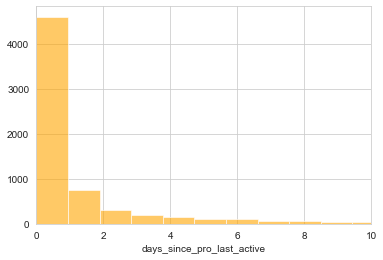

In [85]:
# Use a histplot to understand the distribution of the days_since_last_active data in the Local Moving dataset
lm_df["days_since_pro_last_active"].hist(bins=1000, stacked=True, color='orange', alpha=0.6)
plt.xlabel('days_since_pro_last_active')
plt.xlim(0,10)

Most Local Moving pros were last active the same day of the vistor's search 

In [86]:
# mean days since last active
print('The mean of "days_since_pro_last_active" is %.2f' %(lm_df["days_since_pro_last_active"].mean(skipna=True)))
# median days since last active
print('The median of "days_since_pro_last_active" is %.2f' %(lm_df["days_since_pro_last_active"].median(skipna=True)))

The mean of "days_since_pro_last_active" is 3.68
The median of "days_since_pro_last_active" is 0.00


(0, 40000)

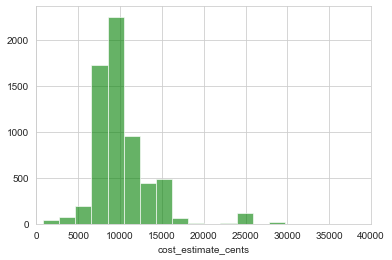

In [87]:
# Now let's look into the cost_estimate_cents data
# Use a plot to understand the distribution of the cost_estimate_cents data in the Local Moving dataset
lm_df["cost_estimate_cents"].hist(bins=15, stacked=True, color='green', alpha=0.6)
plt.xlabel('cost_estimate_cents')
plt.xlim(0,40000)

In [88]:
# mean cost_estimate_cents
print('The mean of "cost_estimate_cents" is %.2f' %(lm_df["cost_estimate_cents"].mean(skipna=True)))
# median cost_estimate_cents
print('The median of "cost_estimate_cents" is %.2f' %(lm_df["cost_estimate_cents"].median(skipna=True)))

The mean of "cost_estimate_cents" is 10227.30
The median of "cost_estimate_cents" is 9500.00


Because are cost data is also right skewed, we will use the median cost to fill our NaN values.

### Step 4: Replacing missing values and dropping unncessary columns

In [89]:
# Copy datasets
hc_data = hc_df.copy()
lm_data = lm_df.copy()

# fill NaN values in avg_rating column with mean of avg_rating
hc_data["avg_rating"].fillna(hc_data["avg_rating"].mean(skipna=True), inplace=True)
lm_data["avg_rating"].fillna(lm_data["avg_rating"].mean(skipna=True), inplace=True)

# drop search timestamp and pro_last_active timestamp
hc_data.drop(['pro_last_active_time_before_search','search_timestamp'], axis=1, inplace=True)
lm_data.drop(['pro_last_active_time_before_search','search_timestamp'], axis=1, inplace=True)

# replce NaN values in "days since last active" with median of that column
hc_data["days_since_pro_last_active"].fillna(hc_data["days_since_pro_last_active"].median(skipna=True), inplace=True)
lm_data["days_since_pro_last_active"].fillna(lm_data["days_since_pro_last_active"].median(skipna=True), inplace=True)

# replace NaN values in cost_estimate_cents with median value
hc_data["cost_estimate_cents"].fillna(hc_data["cost_estimate_cents"].median(skipna=True), inplace=True)
lm_data["cost_estimate_cents"].fillna(lm_data["cost_estimate_cents"].median(skipna=True), inplace=True)

# make new column for cost estimation in dollars
hc_data["cost_estimate_dollars"] = hc_data["cost_estimate_cents"].apply(lambda x: x/100)
lm_data["cost_estimate_dollars"] = lm_data["cost_estimate_cents"].apply(lambda x: x/100)

# drop estimation_cents column
hc_data.drop("cost_estimate_cents", axis=1, inplace=True)
lm_data.drop("cost_estimate_cents", axis=1, inplace=True)

In [90]:
# make contact_id binary variable 1 if contacted, 0 if not 
hc_data['contact_id'] = hc_data["contact_id"].fillna(0)
hc_data['contact_id'] = np.where((hc_data.contact_id == 0),0,1)

lm_data['contact_id'] = lm_data["contact_id"].fillna(0)
lm_data['contact_id'] = np.where((lm_data.contact_id == 0),0,1)

# replace NaN values in hired with False
hc_data['hired'] = hc_data["hired"].fillna(0)
lm_data['hired'] = lm_data["hired"].fillna(0)

# make hired a 0,1 binary variable
hc_data['hired'] = np.where((hc_data.hired == False),0,1)
lm_data['hired'] = np.where((lm_data.hired == False),0,1)

# make service_page_viewed a 0,1 binary variable
hc_data['service_page_viewed'] = np.where((hc_data.service_page_viewed == False),0,1)
lm_data['service_page_viewed'] = np.where((lm_data.service_page_viewed == False),0,1)

In [91]:
hc_data.head()

,row_number,visitor_id,category,pro_user_id,num_reviews,avg_rating,result_position,service_page_viewed,contact_id,hired,days_since_pro_last_active,cost_estimate_dollars
1,8426,344461605879021000,House Cleaning,344053677817806000,0,4.681478,6,0,0,0,1.0,89.0
2,12809,344142189241475000,House Cleaning,343931062348177000,0,4.681478,21,0,0,0,1.0,100.0
3,17310,344215295106097000,House Cleaning,343931062348177000,0,4.681478,22,0,0,0,1.0,100.0
4,10072,344364289304010000,House Cleaning,343934345272852000,0,4.681478,13,0,0,0,1.0,90.0
5,12571,344282205136609000,House Cleaning,343934345272852000,0,4.681478,25,0,0,0,1.0,110.0


### Step 5: More exploratory data analysis

#### Let's start by exploring number of reviews

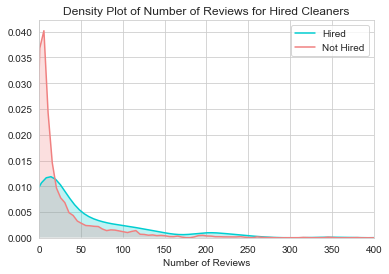

In [92]:
# Create a density plot to view the distribution for the number of reviews for hired vs unhired contractors
# Starting with the House Cleaning Data
ax = sns.kdeplot(hc_data["num_reviews"][hc_data.hired == 1], color="darkturquoise", shade=True)
sns.kdeplot(hc_data["num_reviews"][hc_data.hired == 0], color="lightcoral", shade=True)
plt.legend(['Hired', 'Not Hired'])
plt.title('Density Plot of Number of Reviews for Hired Cleaners')
ax.set(xlabel='Number of Reviews')
plt.xlim(0,400)
plt.show()

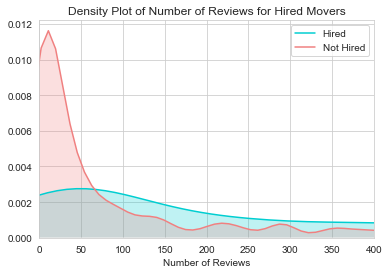

In [93]:
# Creating the same plot for Local Moving
ax = sns.kdeplot(lm_data["num_reviews"][lm_data.hired == 1], color="darkturquoise", shade=True)
sns.kdeplot(lm_data["num_reviews"][lm_data.hired == 0], color="lightcoral", shade=True)
plt.legend(['Hired', 'Not Hired'])
plt.title('Density Plot of Number of Reviews for Hired Movers')
ax.set(xlabel='Number of Reviews')
plt.xlim(0,400)
plt.show()

The distributions for those who were hired vs those were not hired is clearly different. It seems contractors with less reviews are less likely to be hired. This may be a strong predictor in our model later.

#### Exploring Avg. Rating

In [94]:
# Split housing cleaners into avg_rating groups and find hiring rate for each avg_rating group
bins = pd.IntervalIndex.from_tuples([(0, 4), (4, 4.5), (4.5, 4.6), (4.6, 4.7), (4.7, 4.8), (4.8, 4.9), (4.9, 5.0)])
hc_data['hired'].groupby(pd.cut(hc_data['avg_rating'],bins)).mean()

avg_rating
(0.0, 4.0]    0.001380
(4.0, 4.5]    0.008635
(4.5, 4.6]    0.015476
(4.6, 4.7]    0.010152
(4.7, 4.8]    0.017016
(4.8, 4.9]    0.016336
(4.9, 5.0]    0.010323
Name: hired, dtype: float64

In [95]:
# Split movers into avg_rating groups and find hiring rate for each avg_rating group
bins = pd.IntervalIndex.from_tuples([(0, 4), (4, 4.5), (4.5, 4.6), (4.6, 4.7), (4.7, 4.8), (4.8, 4.9), (4.9, 5.0)])
lm_data['hired'].groupby(pd.cut(lm_data['avg_rating'],bins)).mean()

avg_rating
(0.0, 4.0]    0.003922
(4.0, 4.5]    0.030936
(4.5, 4.6]    0.024291
(4.6, 4.7]    0.016840
(4.7, 4.8]    0.036215
(4.8, 4.9]    0.025572
(4.9, 5.0]    0.015385
Name: hired, dtype: float64

As we saw earlier, the mean avg_rating was already extremely high. Based on the data, we can see that generally, the higher the rating, the more likely a contractor is to get hired. Visitors hiring movers seem less sensitive to the movers avg_rating than visitors hiring cleaners. However, the hiring rates among various groups of avg_ratings seems to plateau once the cleaner has an avg_rating above a 4.5 and the mover has an avg_rating above a 4.0. Avg_rating fails to remain as a strong predictor after that point. Therefore, we can say that there must be a stronger predictor among our variables.

#### Exploring Result Position

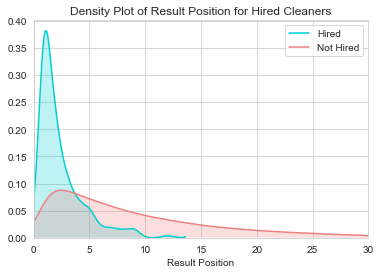

In [96]:
# Create a density plot to view the distribution for the result_position for hired vs unhired contractors
# Starting with the House Cleaning Data
ax = sns.kdeplot(hc_data["result_position"][hc_data.hired == 1], color="darkturquoise", shade=True)
sns.kdeplot(hc_data["result_position"][hc_data.hired == 0], color="lightcoral", shade=True)
plt.legend(['Hired', 'Not Hired'])
plt.title('Density Plot of Result Position for Hired Cleaners')
ax.set(xlabel='Result Position')
plt.xlim(0,30)
plt.show()

In [97]:
# Split cleaners into result_position groups and find hiring rate for each result_position group
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 30)])
hc_data['hired'].groupby(pd.cut(hc_data['result_position'],bins)).mean()

result_position
(0, 1]     0.052409
(1, 2]     0.024458
(2, 3]     0.013740
(3, 4]     0.009247
(4, 5]     0.008817
(5, 30]    0.001479
Name: hired, dtype: float64

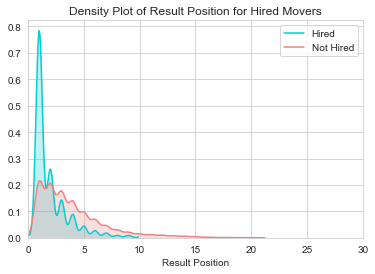

In [98]:
# Create a density plot to view the distribution for the result_position for hired vs unhired contractors
# Starting with the House Cleaning Data
ax = sns.kdeplot(lm_data["result_position"][lm_data.hired == 1], color="darkturquoise", shade=True)
sns.kdeplot(lm_data["result_position"][lm_data.hired == 0], color="lightcoral", shade=True)
plt.legend(['Hired', 'Not Hired'])
plt.title('Density Plot of Result Position for Hired Movers')
ax.set(xlabel='Result Position')
plt.xlim(0,30)
plt.show()

In [99]:
# Split movers into result_position groups and find hiring rate for each result_position group
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 30)])
lm_data['hired'].groupby(pd.cut(lm_data['result_position'],bins)).mean()

result_position
(0, 1]     0.057180
(1, 2]     0.021466
(2, 3]     0.013949
(3, 4]     0.011025
(4, 5]     0.007911
(5, 30]    0.004755
Name: hired, dtype: float64

As we can see from our density plots, the large majority of contractors hired were often the first search result displayed to the visitors. This seems to be a strong predictor for our model.

#### Exploring Cost

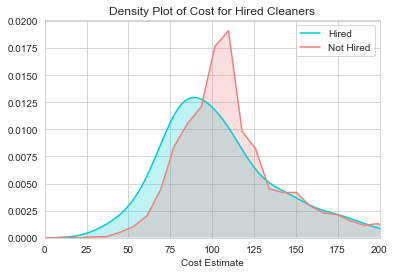

In [100]:
# Create a density plot to view the distribution for the cost estimation for hired vs unhired contractors
# Starting with the House Cleaning Data
ax = sns.kdeplot(hc_data["cost_estimate_dollars"][hc_data.hired == 1], color="darkturquoise", shade=True)
sns.kdeplot(hc_data["cost_estimate_dollars"][hc_data.hired == 0], color="lightcoral", shade=True)
plt.legend(['Hired', 'Not Hired'])
plt.title('Density Plot of Cost for Hired Cleaners')
ax.set(xlabel='Cost Estimate')
plt.xlim(0,200)
plt.show()

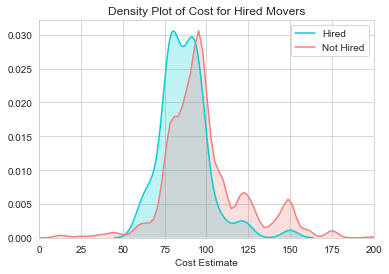

In [101]:
# Create a density plot to view the distribution for the cost estimation for hired vs unhired contractors
# Local Moving data
ax = sns.kdeplot(lm_data["cost_estimate_dollars"][lm_data.hired == 1], color="darkturquoise", shade=True)
sns.kdeplot(lm_data["cost_estimate_dollars"][lm_data.hired == 0], color="lightcoral", shade=True)
plt.legend(['Hired', 'Not Hired'])
plt.title('Density Plot of Cost for Hired Movers')
ax.set(xlabel='Cost Estimate')
plt.xlim(0,200)
plt.show()

The cost distributions between hired and unhired workers are clearly different. Generally, a lower cost estimate is associated with a larger chance of being hired. Furthermore, both the house cleaning and local moving contractors most often hired seem to have price estimates ranging from $75-$100.

#### Exploring days_since_pro_last_active

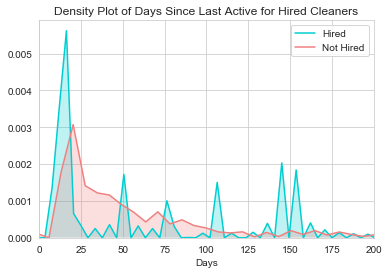

In [102]:
# Create a density plot to view the distribution for the days since last active for hired vs unhired contractors
# Starting with the House Cleaning Data
ax = sns.kdeplot(hc_data["days_since_pro_last_active"][hc_data.hired == 1], color="darkturquoise", shade=True)
sns.kdeplot(hc_data["days_since_pro_last_active"][hc_data.hired == 0], color="lightcoral", shade=True)
plt.legend(['Hired', 'Not Hired'])
plt.title('Density Plot of Days Since Last Active for Hired Cleaners')
ax.set(xlabel='Days')
plt.xlim(0,200)
plt.show()

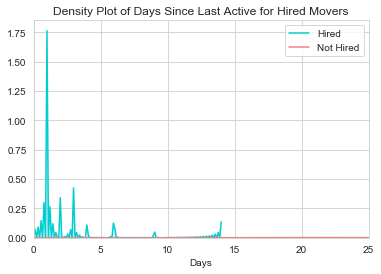

In [103]:
# Create a density plot to view the distribution for the days since last active for hired vs unhired contractors
# Local moving data
ax = sns.kdeplot(lm_data["days_since_pro_last_active"][lm_data.hired == 1], color="darkturquoise", shade=True)
sns.kdeplot(lm_data["days_since_pro_last_active"][lm_data.hired == 0], color="lightcoral", shade=True)
plt.legend(['Hired', 'Not Hired'])
plt.title('Density Plot of Days Since Last Active for Hired Movers')
ax.set(xlabel='Days')
plt.xlim(0,25)
plt.show()

In [104]:
hc_data.head()

,row_number,visitor_id,category,pro_user_id,num_reviews,avg_rating,result_position,service_page_viewed,contact_id,hired,days_since_pro_last_active,cost_estimate_dollars
1,8426,344461605879021000,House Cleaning,344053677817806000,0,4.681478,6,0,0,0,1.0,89.0
2,12809,344142189241475000,House Cleaning,343931062348177000,0,4.681478,21,0,0,0,1.0,100.0
3,17310,344215295106097000,House Cleaning,343931062348177000,0,4.681478,22,0,0,0,1.0,100.0
4,10072,344364289304010000,House Cleaning,343934345272852000,0,4.681478,13,0,0,0,1.0,90.0
5,12571,344282205136609000,House Cleaning,343934345272852000,0,4.681478,25,0,0,0,1.0,110.0


### Step 6: Prepping data for regression

We don't have any categorical variables that need to be transformed.

However, we must drop some columns that we do not want taken into account for our model: row_number, visitor_id, pro_user_id, and category.

We must also seperate the service_page_viewed abd contact_id columns from the dataset to avoid multicollinearity and because we can use page visits and contacts as our target variables in the future.

In [105]:
# drop unneccessary variables
hc_data.drop(['row_number','visitor_id','pro_user_id','category'], axis=1, inplace=True)
lm_data.drop(['row_number','visitor_id','pro_user_id','category'], axis=1, inplace=True)

### Step 7: Regression and results

In [106]:
Xhc = hc_data.copy()
Xlm = lm_data.copy()

hc_hired = Xhc.hired
lm_hired = Xlm.hired

hc_contacted = Xhc.contact_id
lm_contacted = Xlm.contact_id

hc_page_visit = Xhc.service_page_viewed
lm_page_visit = Xlm.service_page_viewed

Xhc.drop(['hired','contact_id','service_page_viewed'], axis=1, inplace=True)
Xlm.drop(['hired','contact_id','service_page_viewed'], axis=1, inplace=True)

In order to use the Y with SciKit Learn, we need to set it as a 1-D array. This means we need to "flatten" the array. Numpy has a built in method for this called ravel

In [107]:
# Flatten arrays
hc_hired = np.ravel(hc_hired)
lm_hired = np.ravel(lm_hired)

hc_contacted = np.ravel(hc_contacted)
lm_contacted = np.ravel(lm_contacted)

hc_page_vist = np.ravel(hc_page_visit)
lm_page_vist = np.ravel(lm_page_visit)

In [108]:
#Create LogisticRegression model
log_model = LogisticRegression()

# Fit our data for house cleaners and set hired as our target
log_model.fit(Xhc,hc_hired)

# Check our accuracy
log_model.score(Xhc,hc_hired)

0.9890836569749134

##### Now let's check the model's coefficients to see which features were most important and then we'll do the same for local movers.

Let's go ahead and compare this to the original Y data. We can do this by simply taking the mean of the Y data, since it is in the format 1 or 0, we can use the mean to calulate the percentage of passengers who survived. This is known as checking the null error rate.

In [109]:
# Check percentage of hired cleaners
print('Percent of hired cleaners is %.2f%%' %(hc_hired.mean()))

Percent of hired cleaners is 0.01%


In [110]:
# Use zip to bring the column names and the np.transpose function to bring together the coefficients from the model
coeff_df = DataFrame(zip(Xhc.columns, np.transpose(log_model.coef_)))

In [111]:
coeff_df

,0,1
0,num_reviews,[0.0012325549774260234]
1,avg_rating,[0.012400715192360214]
2,result_position,[-0.4504537457363683]
3,days_since_pro_last_active,[0.0009230100745836866]
4,cost_estimate_dollars,[-0.003234470678862568]


Let's also look at the p-values for our coefficients

In [118]:
import statsmodels.api as sm
logit_model=sm.Logit(hc_hired,Xhc)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.051813
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                19054
Model:                          Logit   Df Residuals:                    19049
Method:                           MLE   Df Model:                            4
Date:                Fri, 24 Jul 2020   Pseudo R-squ.:                  0.1389
Time:                        20:54:06   Log-Likelihood:                -987.24
converged:                       True   LL-Null:                       -1146.5
                                        LLR p-value:                 1.093e-67
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
num_reviews                    0.0008      0.001      1.142      0.254     

In [113]:
#Create LogisticRegression model for the local moving data
log_model2 = LogisticRegression()

# Fit our data for house cleaners and set hired as our target
log_model2.fit(Xlm,lm_hired)

# Check our accuracy
log_model2.score(Xlm,lm_hired)

0.9780079455164585

In [114]:
# Check percentage of hired movers
print('Percent of hired movers is %.2f%%' %(lm_hired.mean()))

Percent of hired movers is 0.02%


In [115]:
# Use zip to bring the column names and the np.transpose function to bring together the coefficients from the model
coeff_df2 = DataFrame(zip(Xlm.columns, np.transpose(log_model2.coef_)))
coeff_df2

,0,1
0,num_reviews,[0.000454576557131964]
1,avg_rating,[-0.043379212349856026]
2,result_position,[-0.40073272739503696]
3,days_since_pro_last_active,[-0.07214601859321108]
4,cost_estimate_dollars,[-0.021209517976580876]


In [119]:
import statsmodels.api as sm
logit_model=sm.Logit(lm_hired,Xlm)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.096257
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7048
Model:                          Logit   Df Residuals:                     7043
Method:                           MLE   Df Model:                            4
Date:                Fri, 24 Jul 2020   Pseudo R-squ.:                 0.08929
Time:                        20:54:54   Log-Likelihood:                -678.42
converged:                       True   LL-Null:                       -744.93
                                        LLR p-value:                 8.771e-28
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
num_reviews                    0.0004      0.000      1.138      0.255     

### Conclusion:

In conclusion, our model indicates that result position is the largest indicator of a contractor being hired. Having a good avg_rating is important; however, as most contractors have high competitive avg_ratings, the contractor's result position seems to make or break their chances of being hired. 

To help customers find the right pros and make more informed decisions, I reccomend that ThumbTack make the avg_ratings out of 10 instead of 5 and add a new metric to display the number of times the contractor was hired. Furthermore, I would allow customers to filter their searched by these features.